## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import cv2
import os
import random

%matplotlib inline

In [2]:
from tensorflow import keras
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input,Reshape,Flatten
from keras.layers import LSTM,TimeDistributed,Conv2D,MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.utils import plot_model


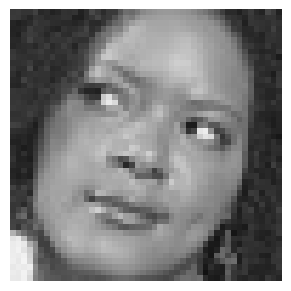

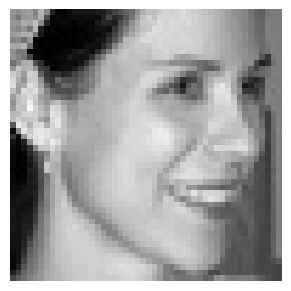

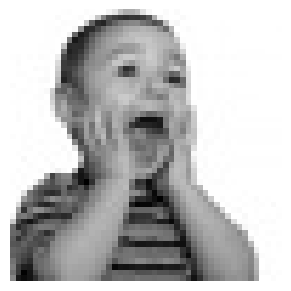

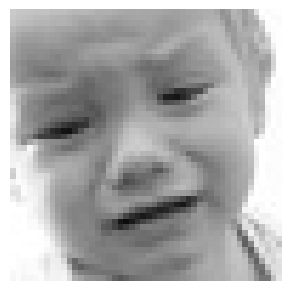

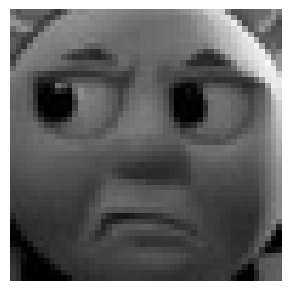

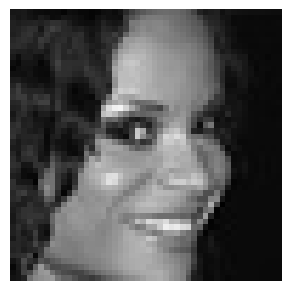

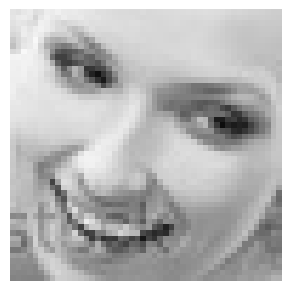

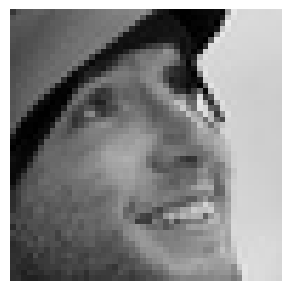

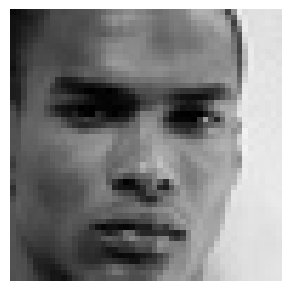

In [3]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

## Preparing the Dataset

In [4]:
img_size = 48
batch_size = 64
sequence_length = 5
num_classes = 7 

datagen_train = ImageDataGenerator(rescale=1./255, rotation_range=10, width_shift_range=0.1,
                                   height_shift_range=0.1, shear_range=0.1, zoom_range=0.1,
                                   horizontal_flip=True, fill_mode='nearest')

train_generator = datagen_train.flow_from_directory('train/',
                                                    target_size=(img_size, img_size),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(rescale=1./255)
validation_generator = datagen_validation.flow_from_directory('test/',
                                                              target_size=(img_size, img_size),
                                                              color_mode='grayscale',
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
def generate_sequence_data(generator, sequence_length):
    while True:
        batch_x, batch_y = next(generator)
        sequence_x = []
        sequence_y = []
        for i in range(len(batch_x)-sequence_length+1):
            sequence_x.append(batch_x[i:i+sequence_length])
            sequence_y.append(batch_y[i+sequence_length-1])
        yield np.array(sequence_x), np.array(sequence_y)


In [6]:
train_sequence_generator = generate_sequence_data(train_generator,sequence_length)
validate_sequence_generator = generate_sequence_data(validation_generator,sequence_length)

## Model Creation

In [7]:
def create_model(input_shape, sequence_length, num_classes):
    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'),
                              input_shape=(sequence_length,) + input_shape))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(256, return_sequences=False))
    
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [8]:
input_shape = (img_size, img_size, 1)
model = create_model(input_shape, sequence_length, num_classes)
model.summary()

c:\Users\SHAIK\.conda\envs\venv\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 5, 48, 48, 64)  │           640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 24, 24, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 5, 24, 24, 128) │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 5, 12, 12, 128) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 5, 18432)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │    19,137,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,347,207 (73.80 MB)

 Trainable params: 19,347,207 (73.80 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
epochs = 5  
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.weights.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
callbacks = [checkpoint, reduce_lr]

## Initializing the Model

In [10]:
history = model.fit(train_sequence_generator,
                    steps_per_epoch = steps_per_epoch,
                    epochs = epochs,
                    validation_data = validate_sequence_generator,
                    validation_steps = validation_steps,
                    callbacks = callbacks) 

Epoch 1/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2563 - loss: 1.8057
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 2062s 5s/step - accuracy: 0.2563 - loss: 1.8057 - val_accuracy: 0.3326 - val_loss: 1.6918 - learning_rate: 1.0000e-04
Epoch 2/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3182 - loss: 1.7020
Epoch 2: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1960s 4s/step - accuracy: 0.3182 - loss: 1.7020 - val_accuracy: 0.3842 - val_loss: 1.5983 - learning_rate: 1.0000e-04
Epoch 3/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3531 - loss: 1.6437
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1900s 4s/step - accuracy: 0.3531 - loss: 1.6437 - val_accuracy: 0.4148 - val_loss: 1.5236 - learning_rate: 1.0000e-04
Epoch 4/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3719 - loss: 1.6009
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━

## Model Evalutaion

In [11]:
batch_size = 64  
evaluation_steps = len(validation_generator)
evaluation_results = model.evaluate(validate_sequence_generator, steps=evaluation_steps, batch_size=batch_size)


113/113 ━━━━━━━━━━━━━━━━━━━━ 100s 889ms/step - accuracy: 0.4407 - loss: 1.4422


## Loss Plot

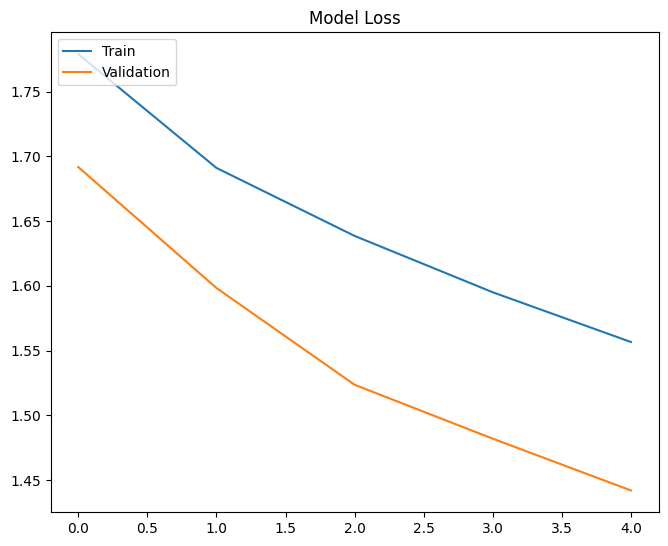

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

## Accuracy Plot

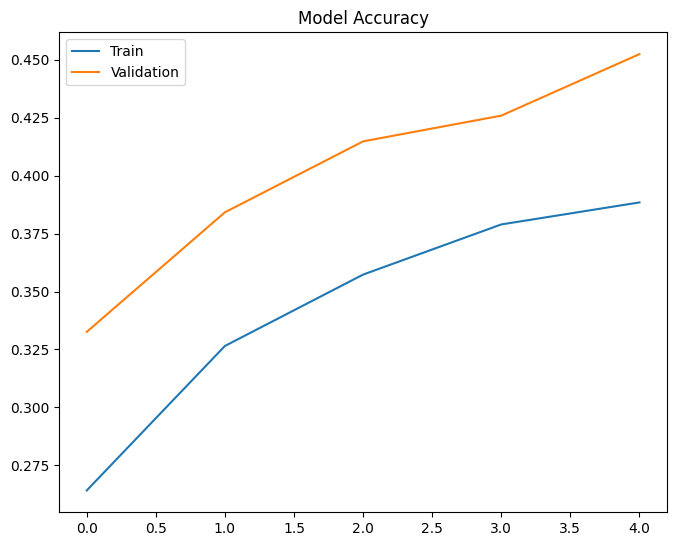

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

## Saving the Model

In [14]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)